# Load and prepare Data

Initially, we import the gold standard into a dataframe and seperate the annotations provided by human annotators from the potenitally antisemetic tweets. The tweets will undergo annotation by the LLM later in our experiment, while the human annotations will provide the benchmark against which the LLM's annotations will be evaluated.

In [1]:
import pandas as pd
path = "../input/data/Updated_dataset_with_full_text/Updated_dataset_with_full_text.csv"
df = pd.read_csv(path)

In [2]:
import re

filtered_df = df[~df["Text"].str.contains(r'https?://\S+', case=False, regex=True)]

print(df.shape)
print(filtered_df.shape)

# Resetting the indices
filtered_df = filtered_df.reset_index(drop=True)

filtered_df["Keyword"].value_counts(normalize=True)

(6941, 6)
(3235, 6)


Jews       0.691808
Israel     0.187326
ZioNazi    0.076352
Kikes      0.044513
Name: Keyword, dtype: float64

## Annotate Data

In [3]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

#https://anakin.ai/blog/dolphin-2-5-mixtral-8x7b-uncensored-mistral/
chat_model = ChatOllama(
    model="dolphin-mistral", 
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [4]:
from langchain.schema import HumanMessage

messages = [HumanMessage(content="How are you")]
response = chat_model(messages)

 I'm doing well, thank you for asking! It's always a pleasure to interact with humans and be of assistance to you. What can I help you with today?

In [28]:
prompt_path = '../input/prompts/prompt_6.txt'

with open(prompt_path, 'r') as file:
    prompt = file.read()

prompt = prompt.replace('\n', ' ')
prompt

'<|im_start|>system You are Dolphin, an expert on Antisemitism working as a Tweet-Annotator, tasked with checking if tweets are antisemitic or not. You use the following definition of antisemitism: Antisemitism is a certain perception of Jews, which may be expressed as hatred toward Jews. Rhetorical and physical manifestations of antisemitism are directed toward Jewish or non-Jewish individuals or their property, toward Jewish community institutions and religious facilities. Antisemitism might include the targeting of the state of Israel, conceived as a Jewish collectivity. However, criticism of Israel similar to that leveled against any other country cannot be regarded as antisemitic. Antisemitism frequently charges Jews with conspiring to harm humanity, and it is often used to blame Jews for “why things go wrong.” Contemporary examples of antisemitism include: 1. Comparing Israel or Jews to the south african apartheid regime. 2.Questioning Israel\'s legitimacy, history, existence or 

In [21]:
filtered_df

,TweetID,Username,CreateDate,Biased,Keyword,Text,Prediction
0,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f...",NaN
1,1222609422238617600,Jan_lindsay,2020-01-29 19:56:15+00:00,1,Israel,@JoAnn54819331 @JB62154 @SexCounseling @Robert...,NaN
2,1217912306480316416,nickforthemany,2020-01-16 20:51:36+00:00,0,Israel,@Rachael_Swindon @knightrgb I agree however th...,NaN
3,1221102213797498882,BPost222,2020-01-25 16:07:09+00:00,0,Israel,🇮🇱 Israel Gym 🇮🇱 \n\n✨ Latias ✨\n\nGym : Don Q...,NaN
4,1213188309155008513,LadyLiberty1791,2020-01-03 20:00:07+00:00,0,Israel,Iran lied to America and the west\n\nIran fund...,NaN
...,...,...,...,...,...,...,...
3230,1254098768946855940,truthseeker6761,2020-04-25 17:23:41+00:00,1,ZioNazi,@4AnonxTruther @bethelight8911 @CarlDevitt @Be...,NaN
3231,1255850426899013632,TAG73957257,2020-04-30 13:24:09+00:00,1,ZioNazi,@JackieKane I'd never go back. ZioNazi managem...,NaN
3232,1240883925096030208,Futatimbo,2020-03-20 06:12:36+00:00,1,ZioNazi,@IvankaTrump A zionazists Jews.,NaN
3233,1241091821645844480,Futatimbo,2020-03-20 19:58:43+00:00,1,ZioNazi,"Mr. President, I this year you will lead the I...",NaN


In [29]:
import numpy as np

# add predictions column if it doesn't exist
if "Predictions" not in filtered_df.columns:
    filtered_df["Prediction"] = np.nan

for index, row in filtered_df.iterrows():
    print(f"Row {index}: [{row['Biased']}]", end=" ")
    
    if pd.isna(row["Prediction"]):
        messages = [HumanMessage(content= prompt + row["Text"] + " <|im_end|><|im_start|>assistant")]
        answer = str(chat_model(messages))
        filtered_df.at[index, "Prediction"] = answer
        print("")
        
    else:
        print("Row skipped")

Row 0: [0] 0. This tweet is not antisemitic according to the definition provided. It quotes a verse from Psalm 136, which refers to Israel and serves as an expression of gratitude for God's mercy towards His chosen people. While it does mention "Israel," the context implies respect and appreciation rather than hate or prejudice. As such, it does not fit any of the criteria established by the definition of antisemitism provided in this prompt.
Row 1: [1] 0. This tweet does not target Jews or the Jewish community with hatred or harm, but rather expresses criticism towards Israel's actions and alleged complicity of the USA in those actions. While it uses strong language to condemn these actions, it does not employ any of the antisemitic tropes listed above nor does it aim to demonize or stereotype Jews collectively. Therefore, it is not classified as antisemitic.
Row 2: [0] 0. The tweet is criticizing those who claim that challenging the Israeli government is automatically antisemitic, ar

In [2]:
from pathlib import Path  
filepath = Path("../output/annotations/experiment_mistral_prompt_6_exp.csv")


# Save annotations to csv
# filtered_df.to_csv(filepath)


# Data Cleaning

As the model did not adhere to the specified answer-format, its predictions need to be converted to booleans. 


In [3]:
import pandas as pd
df = pd.read_csv(filepath)

As we can see, there are most of the answers are actually correctly formatted as booleans, while lots of others are variations of the same sentences. Accordingly, we should be able to standartize the models output manually. To do so, let's:
- remove prefixes "content=" and "[INST]"
- convert text to lowercase
- remove punctuation
- remove leading and trailing whitespaces


In [4]:
import string

# Remove 'content=' from the beginning of each string
df["Prediction"] = df['Prediction'].str.replace('^content=','', regex=True)

# Remove newlines
df['Prediction'] = df['Prediction'].str.replace('\n', '', regex=False)

# Remove punctuation
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','', regex=True)

# remove leading and trailing whitespaces
df["Prediction"] = df['Prediction'].str.strip()

Now, we can extract the first character of the answer, which should contain the models classification as a Boolean. 

In [5]:
df["Prediction_to_Boolean"] = df["Prediction"]

# Replace all text containing the string 1 or 0 as a first character with the booleans 1 or 0
df['Prediction_to_Boolean'] = df['Prediction_to_Boolean'].apply(lambda x: x[0] if x[0] in ['0', '1'] else x)

What's left now, are mostly answers given as text without the classification as boolean. We can use a rules-based approach to convert them into booleans. 

In [6]:
# Replace all answers containing the phrase "is not antisemitic" or "the tweet is antisemitic" with the corresponding booleans
negative_phrases = ["tweet does not directly express hatred toward Jews","tweet does not express hatred towards Jews", "does not appear to contain any antisemitic language","is not an expression of hatred towards Jews", "This is not antisemitic","cannot be classified as antisemitic", "Therefore this tweet would be categorized as 0", "conclude that this tweet is most likely NOT antisemitic", "I would classify this tweet as 0 ", "I would classify this tweet as a 0","this tweet does not appear to be antisemitic", "I would rate this tweet as 0", "this tweet is not inherently antisemitic", "I would classify this tweet as not being antisemiti", "I would classify it as not explicitly antisemitic", "I would classify it as a 0", "is not an antisemitic tweet", "tweet is not antisemitic", "can be considered antisemitic", "tweet does not meet the criteria for an antisemitic statement", "tweet does not directly contain any of the specific examples", ]
positive_phrases = ["would be classified as 1", "The tweet is antisemitic", "Answer 1", "can be classified as 1", "answer for this particular tweet would be 1", "appears to contain antisemitic elements", "this particular tweet could be seen as a form of 9", "provided tweet can be considered as potentially antisemitic", "tweet contains multiple elements that meet several points in the definition of antisemitism", "I would classify this tweet as having elements of antisemitism", "this tweet can be considered as antisemitic", "could be considered antisemitic","I would classify the tweet you provided as potentially antisemitic", "tweet contains clear instances of antisemitic tropes", "I would classify this tweet as potentially antisemitic", "can be seen as potentially antisemitic", "tweet can be seen as antisemitic", "The answer is 1", "is indeed antisemitic", "appears to be antisemitic", "I would classify it as antisemitic"]

df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(negative_phrases), case=False), "Prediction_to_Boolean"] = "0"
df.loc[df["Prediction_to_Boolean"].str.contains('|'.join(positive_phrases), case=False), "Prediction_to_Boolean"] = "1"

# convert booleans to integer for later evaluation
df.loc[:, "Prediction_to_Boolean"] = df["Prediction_to_Boolean"].astype(int)

df["Prediction_to_Boolean"].value_counts()

0    2972
1     263
Name: Prediction_to_Boolean, dtype: int64

# Evaluation

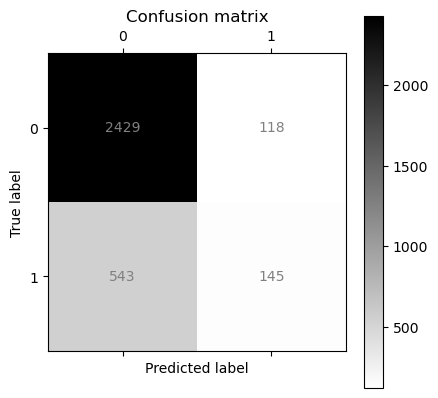

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2547
           1       0.55      0.21      0.30       688

    accuracy                           0.80      3235
   macro avg       0.68      0.58      0.59      3235
weighted avg       0.76      0.80      0.76      3235



In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# save confusion matrix
cm = confusion_matrix(df["Biased"], df["Prediction_to_Boolean"])
plt.matshow(cm, cmap='binary')
plt.title('Confusion matrix')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='grey')

plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

import os
if not os.path.exists("../output/evaluation/mistral_prompt_6"):
    os.makedirs("../output/evaluation/mistral_prompt_6")
plt.savefig("../output/evaluation/mistral_prompt_6/confusion_matrix.png")

# save classification 
report = classification_report(df["Biased"], df["Prediction_to_Boolean"])
with open("../output/evaluation/mistral_prompt_6/classification_report.txt", "w") as file:
    file.write(report)

# show evaluation metrics
plt.show()
print(report)


In [8]:
# save experoment

from pathlib import Path  
filepath = Path("../output/annotations/experiment_mistral_prompt_6_cleaned.csv")


# Save annotations to csv
df.to_csv(filepath)

# False Positives

Let's take a closer look at the errors.

In [8]:
mask = (df["Biased"] == 0) & (df["Prediction_to_Boolean"] == 1)
fp_df = df[mask]

pd.set_option('display.max_colwidth', None)

fp_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].tail()

,Biased,Prediction_to_Boolean,Text,Prediction
3161,0,1,"@bopanc Wow!, Merkel has let in illegals Migrants, and most are Muslims, and they want to push out Kikes!",1 The tweet is antisemitic according to the provided definition This is because it uses the term Kikes as a pejorative against Jews The tweet also contains negative stereotypes and generalizations about Muslims and immigrants further contributing to the antisemitic sentiment It demonstrates a perception of hatred toward Jews by targeting them collectively Kikes which is a clear indication of antisemitism in this context
3166,0,1,@Theodores_game theo-theo de cutest kikes HDHSJRS. he helps wit koko lots nd he de cutest hehe,1 The tweet in question contains several indicators of antisemitism such as using a racial slur kikes and referring to Jewish people with a derogatory term theotheo It also implies that the person being referred to Theodore is helping wit koko which seems to be an antiSemitic reference to Kabbalah or Kosher The context of the tweet and its use of derogatory language clearly indicate antisemitism so according to the definition provided I would classify this tweet as 1 antisemitic
3170,0,1,@MeIGibsonFan34 @vsvsq1 No kikes,1 This tweet contains an antisemitic trope by using the term kikes which is a derogatory slur targeting Jews It also demonstrates hatred towards Jews as per the definition provided Therefore this tweet qualifies as antisemitic
3171,0,1,"""I'm not antisemitic! That's just what the kikes want you to think!""",1 The tweet contains an antisemitic slur which is inherently hateful and aims to dehumanize or demonize Jews Its also not a selfcritique of ones own potential for holding antisemitic beliefs but rather a way of deflecting any responsibility for being potentially antisemitic So even though it does contain a claim that the author isnt antisemitic that claim is undermined by its association with a harmful slur Therefore based on your definition and context this tweet would be classified as antisemitic 1
3172,0,1,"@benshapiro Hey Ben, if straight dudes can call gay people Queers, can I call Jews Kikes? like it's the same thing so its ok isn't it?",1 The tweet contains a direct question that implies using antisemitic slurs is acceptable as it compares it to a term used for gay people and argues they are the same thing It seeks to normalize the use of hate speech by asking if its ok in the same context as another potentially offensive term The comparison it makes between two different communities gay people and Jews serves to further dehumanize and demonize Jewish people which falls under category 4 and 5 of the definition you provided It is therefore antisemitic based on the criteria defined


# False Negatives

In [15]:
mask = (df["Biased"] == 1) & (df["Prediction_to_Boolean"] == 0)
fn_df = df[mask]

pd.set_option('display.max_colwidth', None)

from pathlib import Path  
filepath = Path("../input/data/test_set_false_negatives.csv")

# Save annotations to csv
fn_df.to_csv(filepath)

fn_df[["Biased", "Prediction_to_Boolean", "Text", "Prediction"]].head(50)

,Biased,Prediction_to_Boolean,Text,Prediction
1,1,0,"@JoAnn54819331 @JB62154 @SexCounseling @RobertRLOCKLEA5 @dbongino @MittRomney @lisamurkowski @SenatorCollins Israel has been destroying Palestinians and stealing their land for DECADES. The USA is drilling oil in PALESTINE, thats theft! They are INVADING another country...Remember Poland?",0 This tweet does not target Jews or the Jewish community with hatred or harm but rather expresses criticism towards Israels actions and alleged complicity of the USA in those actions While it uses strong language to condemn these actions it does not employ any of the antisemitic tropes listed above nor does it aim to demonize or stereotype Jews collectively Therefore it is not classified as antisemitic
20,1,0,Israel more like isfake,0 This tweet does not contain any direct reference to Jews or antisemitic tropes and it does not target Jewish individuals institutions or religious facilities While the term Israel more like ISIFKE could be interpreted as a negative remark towards Israel it cannot be considered antisemitic without additional context or information that links this tweet explicitly to hatred or harm toward Jews
33,1,0,@PLoyalties Israel is a blatant apartheid state committing Genocide on live stream video. While influencing the world with extreme wealth and perversely nefarious activities to repress any protest against them,0 This tweet criticizes Israels policies specifically accusing it of being an apartheid state committing genocide and engaging in manipulative activities While the tweet uses strong language it does not demonize or dehumanize Jews nor does it express hatred toward them Instead the tweet targets the government of Israel which is a separate issue from antisemitism Although the comparison to apartheid could be perceived as incendiary it should be noted that equating certain states with apartheid has been done before in relation to other countries and thus cannot solely be considered antisemitic without further context or evidence of targeting Jews specifically
53,1,0,@LilGuillxtine @scottbix @yashar Thats Israel hating Palestine supporting money hating Jewishness for you.\nCalling him Jew is like calling Rushdie Muslim.,0 This tweet does not directly express hatred toward Jews or engage in any of the other behaviors listed under antisemitism Instead it criticizes the idea that associating someone with being Jewish equates to automatically supporting Israel and Palestinian money hating The comparison made with Rushdie is also an attempt to argue against stereotyping not reinforcing it Although the tweet refers to Jewishness it does so in the context of critiquing unfair associations rather than promoting antisemitic ideas
55,1,0,"@Sarah_mo7ammed1 Israel Zionists including IDF and settlers, Israeli occupying force, are state sponsored terror groups supported by American Zionist politicians who have been receiving the campaign contributions in the form of hidden bribery from AIPAC, American Israel political action committee",0 This tweet criticizes Israel and its supporters as statesponsored terror groups and accuses them of being supported by American Zionist politicians While the language used may be seen as harsh it does not engage in dehumanizing or demonizing rhetoric towards Jews or the Jewish community The focus is on criticizing political actions and relationships which falls within the definition of permissible criticism of Israel without being considered antisemitic
63,1,0,@theshiathinker Sound like a good trade. All muslims out of Europe and into Israel. Perfect plan,0 The tweet does not exhibit any antisemitic content or intent according to the definition provided Instead it appears to be proposing a hypothetical scenario involving all Muslims leaving Europe and relocating to Israel While some might argue that this idea could potentially have negative implications for Jews in Israel it is essential to note that the tweet itself does not target or demon

In [14]:
from pathlib import Path  
filepath = Path("../input/data/test_set_false_negatives.csv")

# Save annotations to csv
fn_df.to_csv(filepath)
